# Tutorial for cross attention analysis learned by`PICASA` using normal pancreas dataset.

In [7]:
import anndata as ad
import pandas as pd
import os 
import glob 
from picasa import model,dutil
import matplotlib.pylab as plt
import seaborn as sns
import torch
import numpy as np


Read expression data for all batches.

In [3]:
sample ='pancreas'
pp = '/home/BCCRC.CA/ssubedi/projects/experiments/picasa/picasa_reproducibility/analysis/'

############ read original data as adata list

ddir = pp+sample+'/model_data/'
pattern = sample+'_*.h5ad'

file_paths = glob.glob(os.path.join(ddir, pattern))
file_names = [os.path.basename(file_path) for file_path in file_paths]

batch_map = {}
batch_count = 0
for file_name in file_names:
	print(file_name)
	batch_map[file_name.replace('.h5ad','').replace(sample+'_','')] = ad.read_h5ad(ddir+file_name)
	batch_count += 1
	if batch_count >=25:
		break

picasa_data = batch_map

############ read model results as adata 
wdir = pp+sample
picasa_adata = ad.read_h5ad(wdir+'/model_results/picasa.h5ad')


pancreas_fluidigmc1.h5ad
pancreas_indrop1.h5ad
pancreas_celseq.h5ad
pancreas_indrop4.h5ad
pancreas_indrop2.h5ad
pancreas_indrop3.h5ad
pancreas_smartseq2.h5ad
pancreas_celseq2.h5ad


Load picasa common net model for pancreas data (previously trained following tutorial 1).

In [5]:
nn_params = picasa_adata.uns['nn_params']
nn_params['device'] = 'cpu'
picasa_common_model = model.PICASACommonNet(nn_params['input_dim'], nn_params['embedding_dim'],nn_params['attention_dim'], nn_params['latent_dim'], nn_params['encoder_layers'], nn_params['projection_layers'],nn_params['corruption_tol'],nn_params['pair_importance_weight']).to(nn_params['device'])
picasa_common_model.load_state_dict(torch.load(wdir+'/model_results/picasa_common.model', weights_only=True, map_location=torch.device(nn_params['device'])))


<All keys matched successfully>

For each cell, we have 2000 x 2000 attention matrix. 

Here, we take min 5 and max 100 cells sample for each celltype and estimate average attention scores.

In [6]:
df = pd.DataFrame()
patient_analyzed =[]
sel_batch = ['indrop1','celseq','fluidigmc1','smartseq2']
for pairs in picasa_adata.uns['adata_pairs']:
    
	p1 = picasa_adata.uns['adata_keys'][pairs[0]]
	p2 = picasa_adata.uns['adata_keys'][pairs[1]]

	if p1 not in patient_analyzed and p1 in sel_batch:
		adata_p1 = picasa_data[p1]
		adata_p2 = picasa_data[p2]
		df_nbr = picasa_adata.uns['nbr_map']
		df_nbr = df_nbr[df_nbr['batch_pair']==p1+'_'+p2]
		nbr_map = {x:(y,z) for x,y,z in zip(df_nbr['key'],df_nbr['neighbor'],df_nbr['score'])}

		data_loader = dutil.nn_load_data_pairs(adata_p1, adata_p2, nbr_map,'cpu',batch_size=10)
		eval_total_size=1000
		main_attn,main_y = model.eval_attention_common(picasa_common_model,data_loader,eval_total_size)

		##############################################

		unique_celltypes = adata_p1.obs['celltype'].unique()
  
		num_celltypes = len(unique_celltypes)

		for idx, ct in enumerate(unique_celltypes):
			
			ct_ylabel = adata_p1.obs[adata_p1.obs['celltype'] == ct].index.values
			ct_yindxs = np.where(np.isin(main_y, ct_ylabel))[0]

			min_cells = 5
			if len(ct_yindxs) < min_cells:
				continue
			if len(ct_yindxs) > 100:
				ct_yindxs = np.random.choice(ct_yindxs, 100, replace=False)

			df_attn = pd.DataFrame(np.mean(main_attn[ct_yindxs], axis=0),
								index=adata_p1.var.index.values, columns=adata_p1.var.index.values)
			np.fill_diagonal(df_attn.values, 0)
			df_attn.index = [p1+'@'+ct+'_'+x for x in df_attn.index]
			df = pd.concat([df, df_attn], axis=0)
			print(p1,ct,len(ct_yindxs),df.shape)
			patient_analyzed.append(p1)

fluidigmc1 ductal 34 (2000, 2000)
fluidigmc1 beta 100 (4000, 2000)
fluidigmc1 alpha 100 (6000, 2000)
fluidigmc1 activated_stellate 16 (8000, 2000)
fluidigmc1 acinar 21 (10000, 2000)
fluidigmc1 endothelial 14 (12000, 2000)
fluidigmc1 gamma 18 (14000, 2000)
fluidigmc1 delta 25 (16000, 2000)
fluidigmc1 schwann 5 (18000, 2000)
indrop1 acinar 64 (20000, 2000)
indrop1 beta 100 (22000, 2000)
indrop1 delta 100 (24000, 2000)
indrop1 activated_stellate 35 (26000, 2000)
indrop1 ductal 66 (28000, 2000)
indrop1 alpha 100 (30000, 2000)
indrop1 gamma 36 (32000, 2000)
indrop1 endothelial 69 (34000, 2000)
indrop1 quiescent_stellate 43 (36000, 2000)
indrop1 macrophage 9 (38000, 2000)
indrop1 epsilon 5 (40000, 2000)
celseq gamma 18 (42000, 2000)
celseq acinar 100 (44000, 2000)
celseq alpha 100 (46000, 2000)
celseq delta 50 (48000, 2000)
celseq beta 100 (50000, 2000)
celseq ductal 100 (52000, 2000)
celseq endothelial 5 (54000, 2000)
celseq activated_stellate 19 (56000, 2000)
smartseq2 gamma 88 (58000, 200

In [12]:
unique_celltypes = ['alpha', 'beta', 'delta','acinar','ductal','gamma']


##############################################

dfl = pd.DataFrame(df.index.values)
dfl['patient'] = [x.split('@')[0] for x in dfl[0]]
dfl['celltype'] = [x.split('@')[1].split('_')[0] for x in dfl[0]]

dfl = dfl[dfl['celltype'].isin(unique_celltypes)]

dfl['gene'] = [x.split('_')[1] for x in dfl[0]]
dfl.drop(0,axis=1,inplace=True)
dfl.reset_index(inplace=True)



Once we get the average attention scores for each cell type for all batches, we conduct the following analysis -

- Check activity of known markers for different cell types.

(8000, 2000)
(8000, 2000)
(8000, 2000)
(8000, 2000)
(8000, 2000)
(8000, 2000)


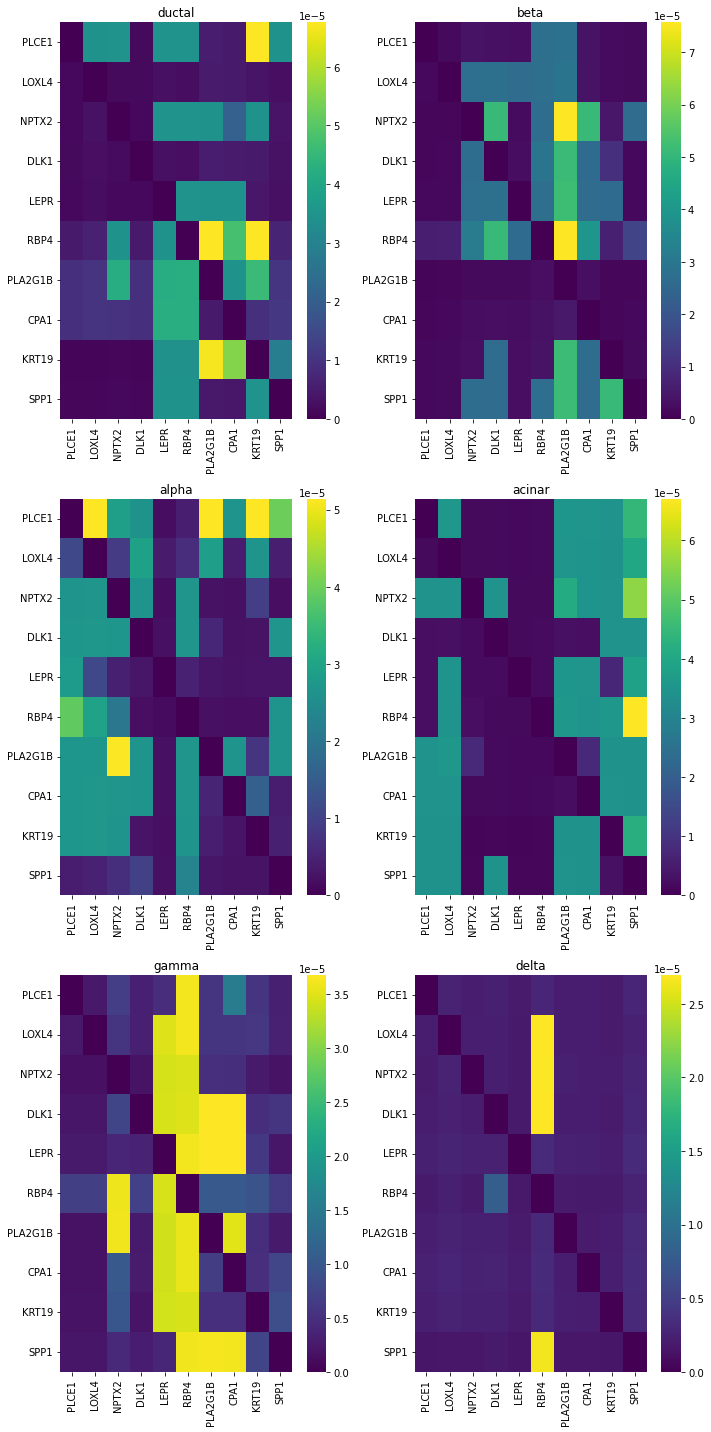

In [13]:

########  cell type markers
marker = [
'PLCE1','LOXL4',#alpha
'NPTX2','DLK1',#beta
'LEPR','RBP4',#delta
'PLA2G1B','CPA1',#acinar
'KRT19','SPP1',#ductal
    
]

unique_celltypes = dfl['celltype'].unique()

fig, axes = plt.subplots(3, 2, figsize=(10, 20))

for idx, ct in enumerate(unique_celltypes):
    
    row, col = idx // 2, idx % 2
    
    ct_ylabel = dfl[dfl['celltype'] == ct].index.values
    df_attn = df.iloc[ct_ylabel,:].copy()
    df_attn = df_attn.astype(np.float32)
    print(df_attn.shape)
    
    df_attn[df_attn > np.float32(0.0001)] = np.float32(0.0001)

    sel_genes = [x for x in marker if x in df_attn.columns]
    df_attn = df_attn.loc[:,sel_genes]
    
    df_attn['gene'] = [x.split('_')[1] for x in df_attn.index.values]
    df_attn = df_attn[df_attn['gene'].isin(sel_genes)]
    df_attn = df_attn.groupby('gene').mean()
    
    df_attn = df_attn.loc[sel_genes,sel_genes]
    
    df_attn.columns = [x.split('-')[0] for x in df_attn.columns]
    df_attn.index = [x.split('-')[0] for x in df_attn.index]
    sns.heatmap(df_attn, ax=axes[row, col],
                yticklabels=df_attn.index,  
                xticklabels=df_attn.columns,  
                cmap='viridis' 
                )
    axes[row, col].set_title(ct)
    
plt.tight_layout()

- Check activity of the entire 2000 genes for different cell types.

ductal
beta
alpha
acinar
gamma
delta


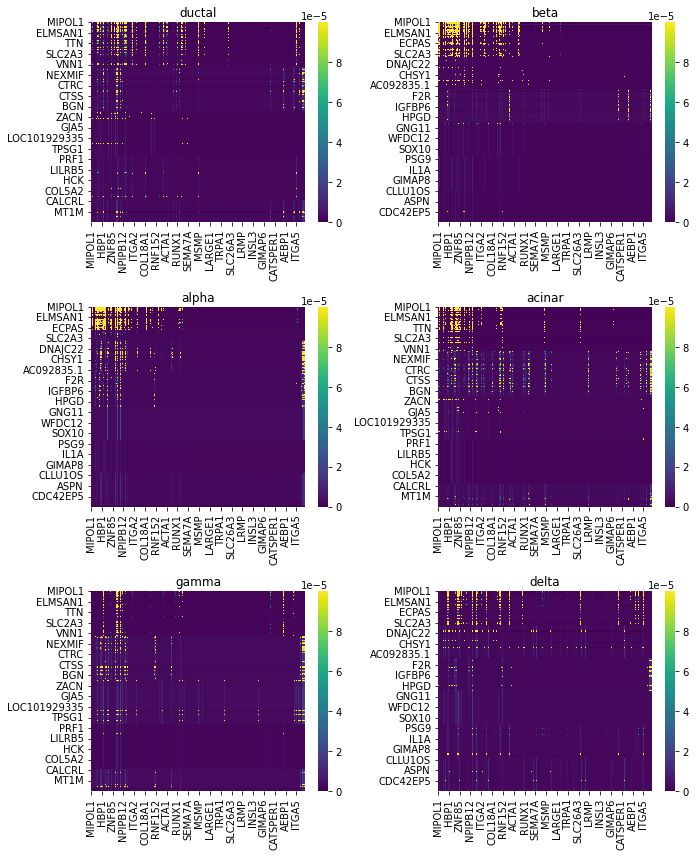

In [15]:

##############################################
def get_top_genes_per_group(df,dfl,unique_celltypes):
    top_genes = {}
    for idx, ct in enumerate(unique_celltypes):
        ct_ylabel = dfl[dfl['celltype'] == ct].index.values
        df_attn = df.iloc[ct_ylabel,:].copy()
        
        df_attn['gene'] = [x.split('_')[1] for x in df_attn.index.values]
        df_attn = df_attn.groupby('gene').mean()
        df_attn = df_attn.unstack().reset_index()
        df_attn = df_attn.sort_values(0,ascending=False)
        tp1 = df_attn['gene'].unique()
        top_genes[ct]=tp1
    return top_genes
        


marker = get_top_genes_per_group(df,dfl,unique_celltypes)
seq_marker = marker['alpha']

fig, axes = plt.subplots(3, 2, figsize=(10, 12))

for idx, ct in enumerate(unique_celltypes):
    
    print(ct)
    
    row, col = idx // 2, idx % 2
    
    ct_ylabel = dfl[dfl['celltype'] == ct].index.values
    df_attn = df.iloc[ct_ylabel,:].copy()
    

    df_attn.index = [x.split('_')[1] for x in df_attn.index.values]
    df_attn = df_attn.loc[seq_marker,seq_marker]
    
    df_attn[df_attn > np.float32(0.0001)] = np.float32(0.0001)

    sns.heatmap(df_attn, ax=axes[row, col],
                cmap='viridis' 
                )
    axes[row, col].set_title(ct)
    
plt.tight_layout()



Use `PanglaoDB_Augmented_2021` database for gene set enrichment analysis using ranked genes for different cell types.

Running GSEA for PanglaoDB_Augmented_2021


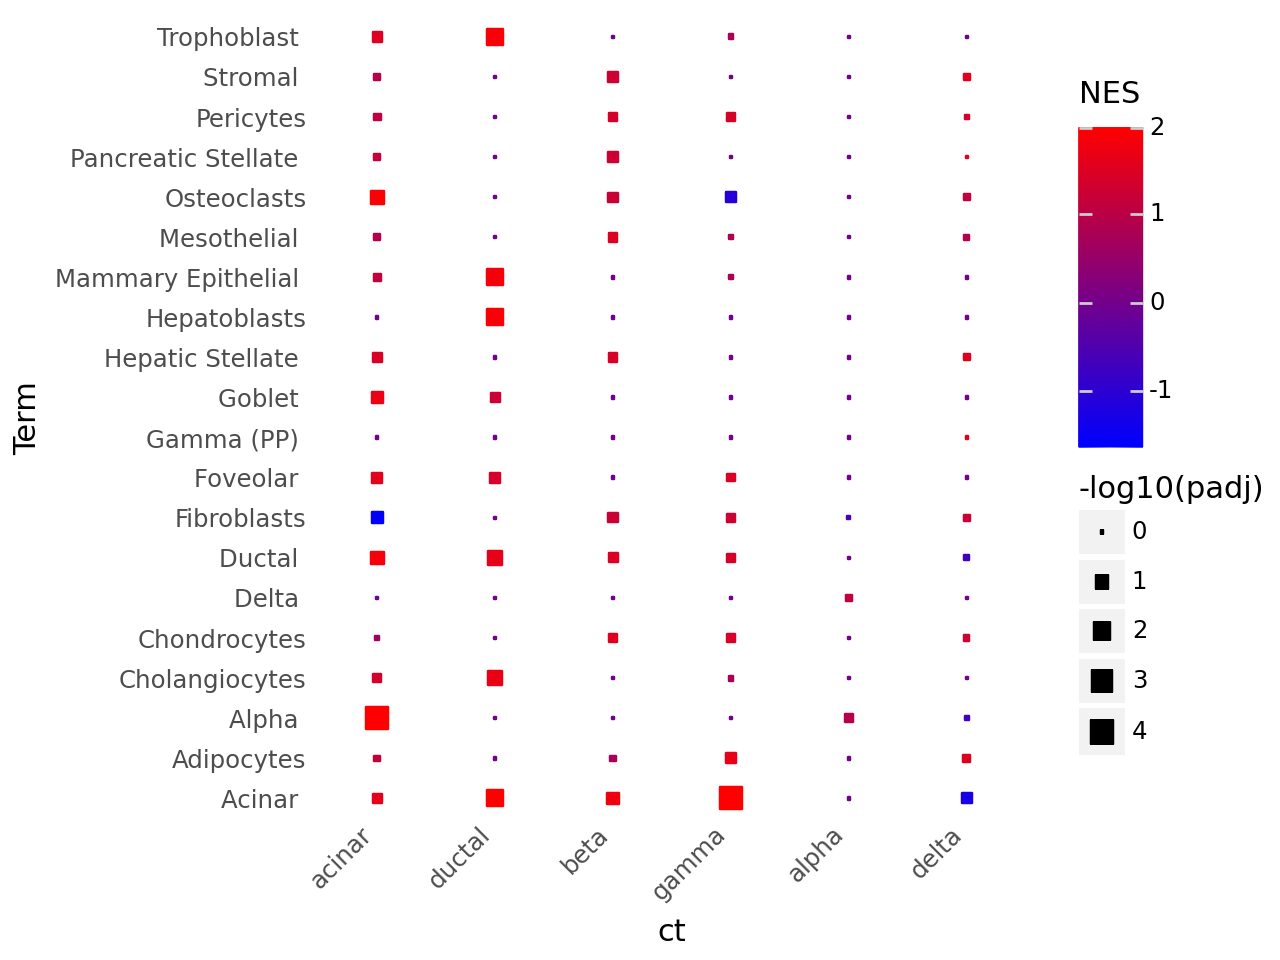

In [23]:


ranked_gene_list = {}
top_n = 2000 ## this is ok as total gene is 2k so all ranked
for idx, ct in enumerate(unique_celltypes):
	ct_ylabel = dfl[dfl['celltype'] == ct].index.values
	df_attn = df.iloc[ct_ylabel,:].copy()
	
	df_attn['gene'] = [x.split('_')[1] for x in df_attn.index.values]
	df_attn = df_attn.groupby('gene').mean()
 
	df_attn = df_attn.unstack().reset_index()

	df_attn.columns = ['Gene1','Gene2','Score']
	df_attn = df_attn.sort_values('Score',ascending=False)
 
	df_attn = df_attn.iloc[:top_n,:]

	df_attn = pd.melt(df_attn, 
					id_vars=['Score'], 
					value_vars=['Gene1', 'Gene2'], 
					var_name='Gene_Type', 
					value_name='Gene')

	df_attn = df_attn[['Gene','Score']]
	df_attn = df_attn.drop_duplicates(subset='Gene') 
	df_attn['Score'] = df_attn['Score'] + (0.1*(df_attn.index.values[::-1]))
	df_attn['Gene'] = df_attn['Gene'].str.upper()
	ranked_gene_list[ct] = df_attn.reset_index(drop=True)
	

import gseapy as gp
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
from plotnine import *
pd.set_option('future.no_silent_downcasting', True)

available_libraries = gp.get_library_name(organism="Human")

dbs = [
	'PanglaoDB_Augmented_2021' 
	]

pval_col = 'FDR q-val' 
nes_col = 'NES'  
min_size, max_size = 10, 500  
top_n_pathways = 5

all_pathway_results = {}

for db in dbs:
		print(f"Running GSEA for {db}")
		gene_set_library = gp.get_library(name=db, organism="Human")

		all_pathways = []

		for factor in unique_celltypes:
			gsea_res = gp.prerank(
				rnk=ranked_gene_list[factor],
				gene_sets=gene_set_library,
				min_size=min_size,
				max_size=max_size,
				permutation_num=1000,
				outdir=None,
			)

			all_pathway_results[factor] = gsea_res.res2d

			top_paths = (
				gsea_res.res2d.sort_values(by=nes_col, ascending=False)
				.head(top_n_pathways)["Term"]
				.values
			)
			all_pathways.extend(top_paths)

		selected_pathways = np.unique(all_pathways)

		df_result = pd.DataFrame()

		for factor in unique_celltypes:
			df_gsea = all_pathway_results[factor].set_index("Term")

			df_gsea = df_gsea.reindex(selected_pathways)
			## 1 for pval	
			df_gsea[pval_col] = df_gsea[pval_col].fillna(1.0)
			## 0 for nes
			df_gsea[nes_col] = df_gsea[nes_col].fillna(0.0)

			df_gsea["ct"] = factor
			df_result = pd.concat([df_result, df_gsea], axis=0)

		df_result[pval_col] = pd.to_numeric(df_result[pval_col], errors='coerce')
		df_result[nes_col] = pd.to_numeric(df_result[nes_col], errors='coerce')
		pval_col_log = '-log10(padj)'
		df_result[pval_col_log] = -np.log10(df_result[pval_col]+1e-8)
		df_result[pval_col_log] = df_result[pval_col_log].clip(lower=0, upper=4)
		df_result[nes_col] = df_result[nes_col].clip(lower=-2, upper=2)
  
  
  
		df_result.reset_index(inplace=True)
		df_result = df_result[[pval_col_log, nes_col,"Term","ct"]]
		pivot_df = df_result.pivot(index="Term", columns="ct", values=nes_col)
		row_linkage = linkage(pivot_df, method="ward")
		col_linkage = linkage(pivot_df.T, method="ward")
		row_order = leaves_list(row_linkage)
		col_order = leaves_list(col_linkage)
  
		df_result["Term"] = pd.Categorical(df_result["Term"], categories=pivot_df.index[row_order], ordered=True)
		df_result["ct"] = pd.Categorical(df_result["ct"], categories=pivot_df.columns[col_order], ordered=True)


		df_result['Term'] = [x.replace('Cells','') for x in df_result['Term']]		
		##save before plot
  
		p = (ggplot(df_result, aes(x='ct', y='Term', color='NES', size=pval_col_log)) 
				# + geom_point()
				+ geom_point(shape='s')
				+ scale_color_gradient(low="blue", high="red")
				+ scale_size_continuous(range=(0, 4))
				+ theme(panel_grid=element_blank(),  
						panel_background=element_blank(),
						axis_line=element_blank(),  
						axis_ticks=element_blank(),  
						axis_text_x=element_text(rotation=45, hjust=1),
						plot_background=element_rect(fill='white', color='white',
						)  
						)  
		)

from IPython.display import display

display(p)
    